# Conditional generator-based conditional tabular GAN (CTGAN)

In [ ]:
from re import search
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn import metrics

from sklearn.svm import LinearSVC


from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score

from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [ ]:
pip install ctgan

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

Time        V1        V2        V3  ...       V27       V28  Amount  Class
0   0.0 -1.359807 -0.072781  2.536347  ...  0.133558 -0.021053  149.62      0
1   0.0  1.191857  0.266151  0.166480  ... -0.008983  0.014724    2.69      0
2   1.0 -1.358354 -1.340163  1.773209  ... -0.055353 -0.059752  378.66      0
3   1.0 -0.966272 -0.185226  1.792993  ...  0.062723  0.061458  123.50      0
4   2.0 -1.158233  0.877737  1.548718  ...  0.219422  0.215153   69.99      0

[5 rows x 31 columns]

In [ ]:
raw_df[['Time','V1','V2','V3','V4','V5','V26','V27','V28','Amount','Class']].describe()

Time            V1  ...         Amount          Class
count  284807.000000  2.848070e+05  ...  284807.000000  284807.000000
mean    94813.859575  3.919560e-15  ...      88.349619       0.001727
std     47488.145955  1.958696e+00  ...     250.120109       0.041527
min         0.000000 -5.640751e+01  ...       0.000000       0.000000
25%     54201.500000 -9.203734e-01  ...       5.600000       0.000000
50%     84692.000000  1.810880e-02  ...      22.000000       0.000000
75%    139320.500000  1.315642e+00  ...      77.165000       0.000000
max    172792.000000  2.454930e+00  ...   25691.160000       1.000000

[8 rows x 11 columns]

In [ ]:

neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



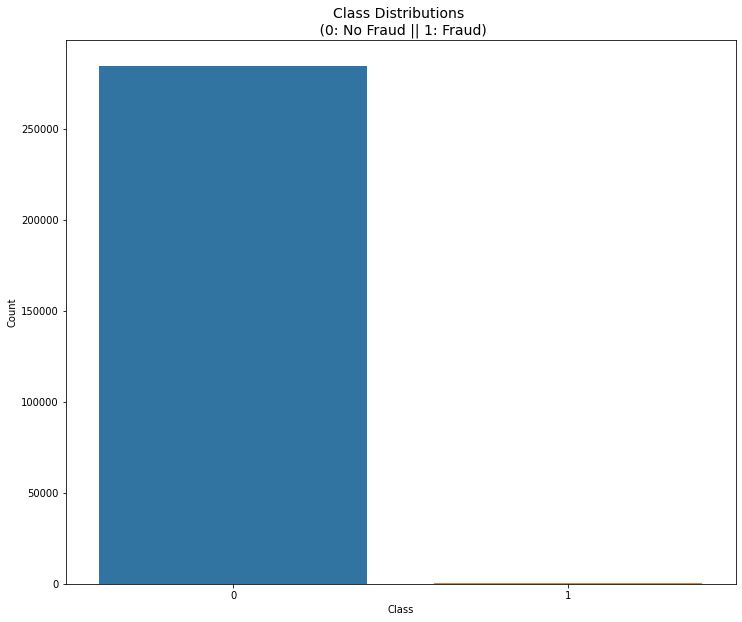

In [ ]:
sns.countplot(x=raw_df["Class"], data=raw_df)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('BinmisMatches.png')

In [ ]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

In [ ]:
cleaned_df.head()

V1        V2        V3  ...       V28  Class  Log Ammount
0 -1.359807 -0.072781  2.536347  ... -0.021053      0     5.008105
1  1.191857  0.266151  0.166480  ...  0.014724      0     0.989913
2 -1.358354 -1.340163  1.773209  ... -0.059752      0     5.936641
3 -0.966272 -0.185226  1.792993  ...  0.061458      0     4.816249
4 -1.158233  0.877737  1.548718  ...  0.215153      0     4.248367

[5 rows x 30 columns]

In [ ]:
cleaned_df.dtypes

V1             float64
V2             float64
V3             float64
V4             float64
V5             float64
V6             float64
V7             float64
V8             float64
V9             float64
V10            float64
V11            float64
V12            float64
V13            float64
V14            float64
V15            float64
V16            float64
V17            float64
V18            float64
V19            float64
V20            float64
V21            float64
V22            float64
V23            float64
V24            float64
V25            float64
V26            float64
V27            float64
V28            float64
Class            int64
Log Ammount    float64
dtype: object

# Exploratory data analysis (EDA)

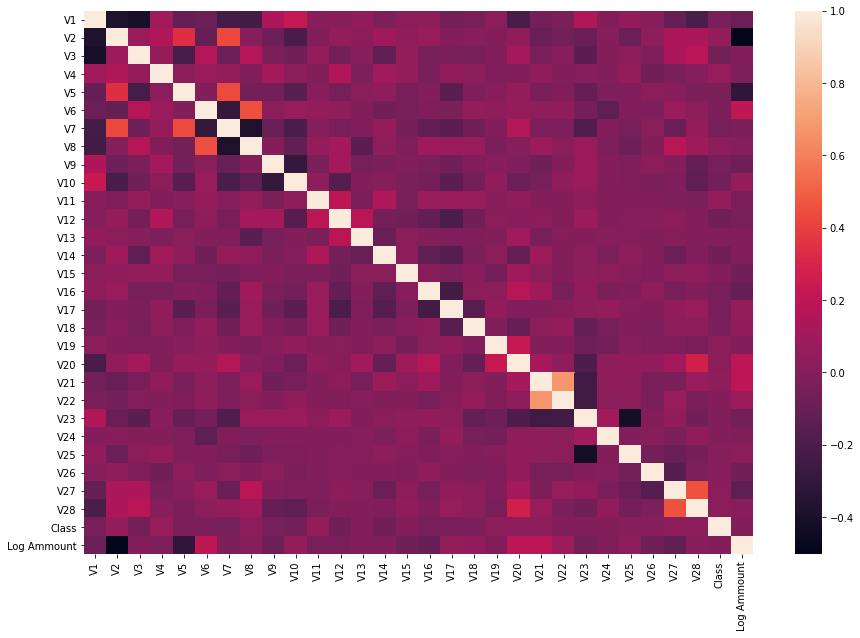

In [ ]:
plt.figure(figsize=(15,10))
corr = cleaned_df.corr(method = 'spearman')
sns.heatmap(corr, annot = False)
plt.show()

In [ ]:
np.random.seed(11) 
non_fraud = cleaned_df[cleaned_df['Class'] == 0].sample(2000)
fraud = cleaned_df[cleaned_df['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

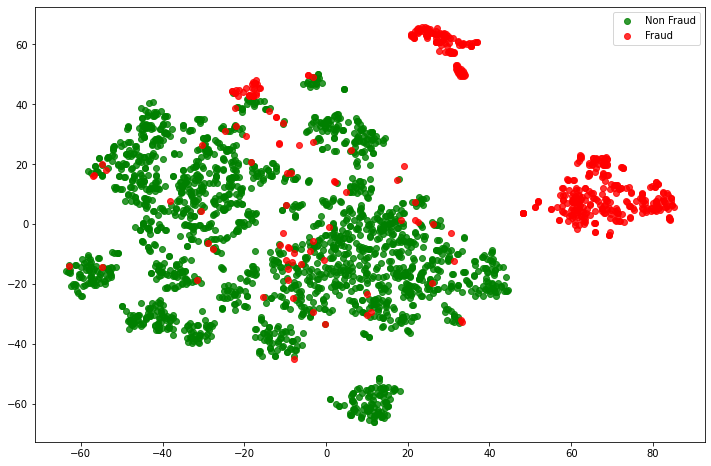

Computational time = 17.396734476089478


In [ ]:
np.random.seed(12) 
from sklearn.manifold import TSNE
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();

status_start_time = time.time()    
tsne_plot(X, Y, "original.png")
status_end_time=time.time()
print ("Computational time = " +str(status_end_time - status_start_time) )

Let's visualize the nature of fraud and non-fraud transactions using T-SNE. T-SNE (t-Distributed Stochastic Neighbor Embedding) is a dataset decomposition technique which reduced the dimentions of data and produces only top n components with maximum information.

Every dot in the following represents a transaction. Non Fraud transactions are represented as Green while Fraud transactions are represented as Red. The two axis are the components extracted by tsne.

From the above graph we can observe that there are many non_fraud transactions which are very close to fraud transactions, thus are difficult to accurately classify from a model.

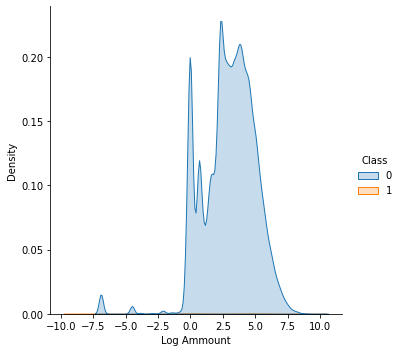

In [ ]:
sns.displot(cleaned_df, x="Log Ammount", hue="Class", kind="kde", fill=True)

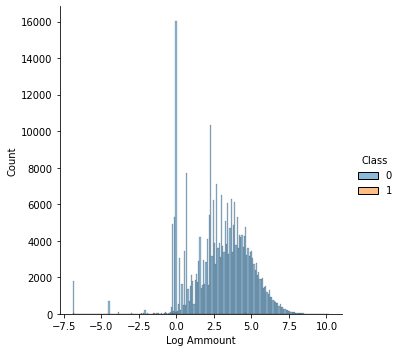

In [ ]:
sns.displot(cleaned_df, x="Log Ammount", hue="Class", )

# CTGAN

In [ ]:
from ctgan import CTGANSynthesizer
ctgan = CTGANSynthesizer()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
np.random.seed(10002) 
# Use a utility from sklearn to split and shuffle our dataset.
train_dfgan, test_dfgan = train_test_split(cleaned_df, test_size=0.2)


In [ ]:
train_dfgan.dtypes

V1             float64
V2             float64
V3             float64
V4             float64
V5             float64
V6             float64
V7             float64
V8             float64
V9             float64
V10            float64
V11            float64
V12            float64
V13            float64
V14            float64
V15            float64
V16            float64
V17            float64
V18            float64
V19            float64
V20            float64
V21            float64
V22            float64
V23            float64
V24            float64
V25            float64
V26            float64
V27            float64
V28            float64
Class            int64
Log Ammount    float64
dtype: object

In [ ]:
train_dfgan.shape

(227845, 30)

In [ ]:
neg_traingan, pos_traingan = np.bincount(train_dfgan['Class'])
totalgan = neg_traingan + pos_traingan
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    totalgan, pos_traingan, 100 * pos_traingan / total))

Examples:
    Total: 227845
    Positive: 406 (0.14% of total)



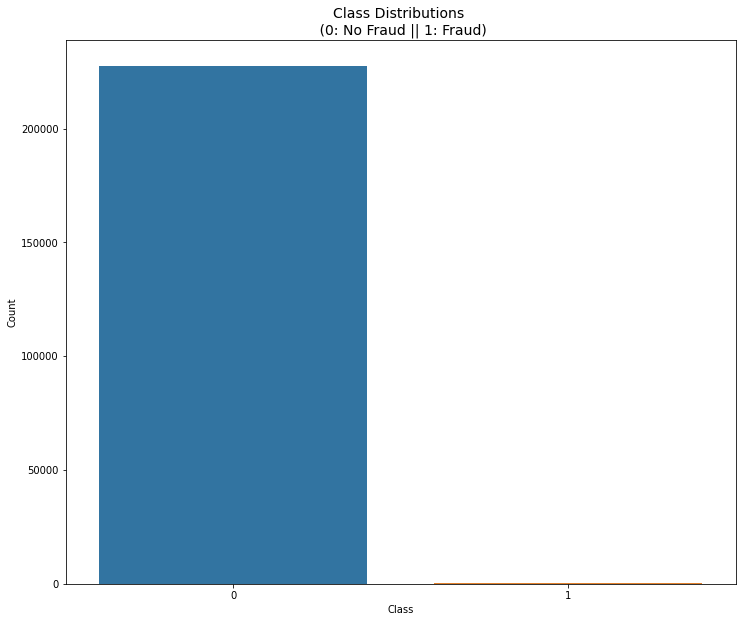

In [ ]:
sns.countplot(x=train_dfgan["Class"], data=train_dfgan)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('BinmisMatches.png')

In [ ]:

train_dfgan.Class= train_dfgan.Class.astype(str)
train_dfgan.dtypes


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


V1             float64
V2             float64
V3             float64
V4             float64
V5             float64
V6             float64
V7             float64
V8             float64
V9             float64
V10            float64
V11            float64
V12            float64
V13            float64
V14            float64
V15            float64
V16            float64
V17            float64
V18            float64
V19            float64
V20            float64
V21            float64
V22            float64
V23            float64
V24            float64
V25            float64
V26            float64
V27            float64
V28            float64
Class           object
Log Ammount    float64
dtype: object

In [ ]:
discrete_columns = ['Class']

In [ ]:
np.random.seed(100) 
start_time = time.time()
ctgan.fit(train_dfgan, discrete_columns,epochs=1)
end_time = time.time()
print ("Computational time = " +str(end_time - start_time) )

Epoch 1, Loss G: -1.2928, Loss D: -0.2817
Computational time = 1051.0917575359344


In [ ]:
np.random.seed(1001) 
gan_samples = ctgan.sample(227845, 'Class', '1')

In [ ]:
gan_samples.head()

V1        V2        V3  ...       V28  Class  Log Ammount
0   0.270092 -0.043158  2.511794  ...  0.149483      0     1.307054
1 -12.329558 -0.461289  0.533640  ...  0.065254      0     0.674311
2  -4.872232 -7.431723 -0.352277  ...  0.213678      0     1.967061
3   1.752176  1.488686  1.716918  ...  0.126957      0    -0.380324
4  -4.153372  1.282895 -0.545226  ...  0.104771      0     2.907606

[5 rows x 30 columns]

In [ ]:
gan_samples.dtypes

V1             float64
V2             float64
V3             float64
V4             float64
V5             float64
V6             float64
V7             float64
V8             float64
V9             float64
V10            float64
V11            float64
V12            float64
V13            float64
V14            float64
V15            float64
V16            float64
V17            float64
V18            float64
V19            float64
V20            float64
V21            float64
V22            float64
V23            float64
V24            float64
V25            float64
V26            float64
V27            float64
V28            float64
Class           object
Log Ammount    float64
dtype: object

In [ ]:
gan_samples["Class"] = gan_samples["Class"].astype(str).astype(int)
print(gan_samples.dtypes)

V1             float64
V2             float64
V3             float64
V4             float64
V5             float64
V6             float64
V7             float64
V8             float64
V9             float64
V10            float64
V11            float64
V12            float64
V13            float64
V14            float64
V15            float64
V16            float64
V17            float64
V18            float64
V19            float64
V20            float64
V21            float64
V22            float64
V23            float64
V24            float64
V25            float64
V26            float64
V27            float64
V28            float64
Class            int64
Log Ammount    float64
dtype: object


In [ ]:
neg_gansamples, pos_gansamples = np.bincount(gan_samples['Class'])
totalgansamples = neg_gansamples + pos_gansamples
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    totalgansamples, pos_gansamples, 100 * pos_gansamples / totalgansamples))

Examples:
    Total: 227845
    Positive: 30715 (13.48% of total)



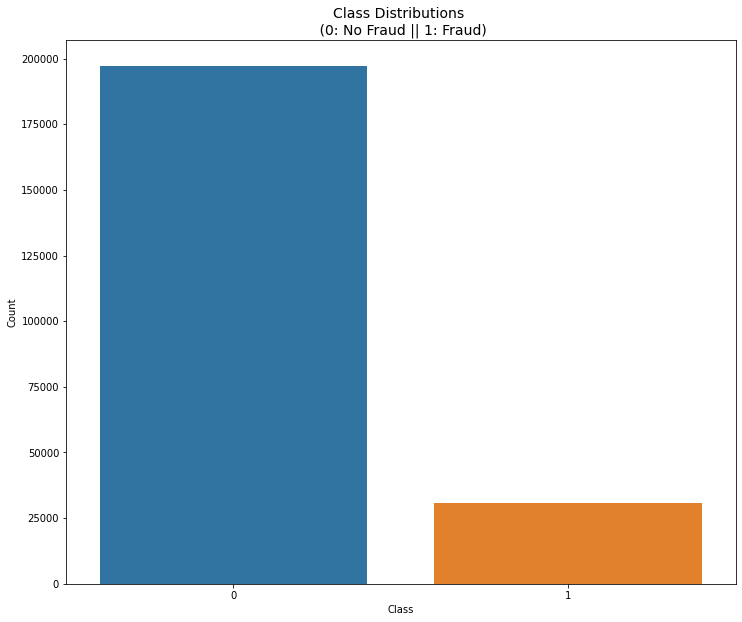

In [ ]:
sns.countplot(x=gan_samples["Class"], data=gan_samples)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('BinmisMatches.png')

# Classification

In [ ]:
np.random.seed(31) 
# Use a utility from sklearn to split and shuffle our dataset.
train_dfgan, test_dfgan = train_test_split(gan_samples, test_size=0.2)
train_dfgan, val_dfgan = train_test_split(train_dfgan, test_size=0.2)

# Form np arrays of labels and features.
train_labelsgan = np.array(train_dfgan.pop('Class'))
bool_train_labelsgan = train_labelsgan != 0
val_labelsgan = np.array(val_dfgan.pop('Class'))
test_labelsgan = np.array(test_dfgan.pop('Class'))

train_featuresgan = np.array(train_dfgan)
val_featuresgan = np.array(val_dfgan)
test_featuresgan = np.array(test_dfgan)

In [ ]:

np.random.seed(32) 
scaler = StandardScaler()
train_featuresgan = scaler.fit_transform(train_featuresgan)

val_featuresgan = scaler.transform(val_featuresgan)
test_featuresgan = scaler.transform(test_featuresgan)

train_featuresgan = np.clip(train_featuresgan, -5, 5)
val_featuresgan = np.clip(val_featuresgan, -5, 5)
test_featuresgan = np.clip(test_featuresgan, -5, 5)


print('Training labels shape:', train_labelsgan.shape)
print('Validation labels shape:', val_labelsgan.shape)
print('Test labels shape:', test_labelsgan.shape)

print('Training features shape:', train_featuresgan.shape)
print('Validation features shape:', val_featuresgan.shape)
print('Test features shape:', test_featuresgan.shape)

Training labels shape: (145820,)
Validation labels shape: (36456,)
Test labels shape: (45569,)
Training features shape: (145820, 29)
Validation features shape: (36456, 29)
Test features shape: (45569, 29)


In [ ]:
np.random.seed(5) 
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_featuresgan.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [ ]:
np.random.seed(6) 
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
np.random.seed(10003) 


In [ ]:
np.random.seed(7) 
model = make_model()
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 16)                480       
_________________________________________________________________
dropout_17 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [ ]:
np.random.seed(33) 
model.predict(train_featuresgan[:10])

array([[0.13757266],
       [0.14454354],
       [0.04165732],
       [0.05094505],
       [0.21183166],
       [0.02850308],
       [0.0307584 ],
       [0.131361  ],
       [0.0586976 ],
       [0.05591934]], dtype=float32)

In [ ]:
np.random.seed(34) 
results = model.evaluate(train_featuresgan, train_labelsgan, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.4546


In [ ]:
np.random.seed(35)
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [ ]:
np.random.seed(36)
model = make_model(output_bias=initial_bias)
model.predict(train_featuresgan[:10])

array([[0.00159286],
       [0.01211149],
       [0.00211695],
       [0.00517727],
       [0.00177093],
       [0.0017766 ],
       [0.00152827],
       [0.00184843],
       [0.00224595],
       [0.00061248]], dtype=float32)

In [ ]:
np.random.seed(37)
results = model.evaluate(train_featuresgan, train_labelsgan, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))


Loss: 0.8308


In [ ]:
np.random.seed(38)
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [ ]:
np.random.seed(39)
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_featuresgan,
    train_labelsgan,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_featuresgan, val_labelsgan), 
    verbose=0)

In [ ]:
np.random.seed(40)
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_featuresgan,
    train_labelsgan,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_featuresgan, val_labelsgan), 
    verbose=0)

In [ ]:
np.random.seed(41)
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch, history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

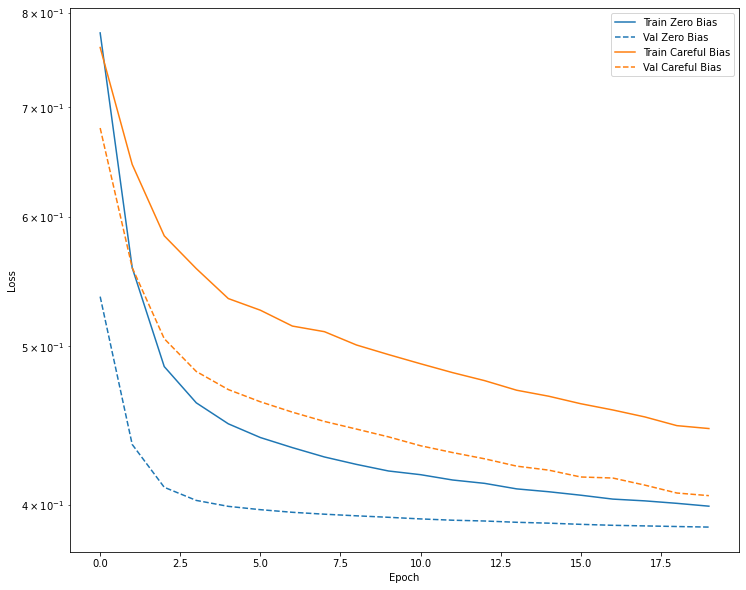

In [ ]:
np.random.seed(42)
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)


In [ ]:
np.random.seed(43)
model = make_model()
start_time = time.time()
model.load_weights(initial_weights)
gan_history = model.fit(
    train_featuresgan,
    train_labelsgan,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_featuresgan, val_labelsgan))
start_time = time.time()
end_time = time.time()
print ("Computational time = " +str(end_time - start_time) )

Epoch 1/100
72/72 [==============================] - 1s 15ms/step - loss: 0.7636 - tp: 33.0000 - fp: 200.0000 - tn: 157641.0000 - fn: 24402.0000 - accuracy: 0.8650 - precision: 0.1416 - recall: 0.0014 - auc: 0.5060 - val_loss: 0.6799 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 31534.0000 - val_fn: 4922.0000 - val_accuracy: 0.8650 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5178
Epoch 2/100
72/72 [==============================] - 0s 7ms/step - loss: 0.6434 - tp: 324.0000 - fp: 1572.0000 - tn: 124735.0000 - fn: 19189.0000 - accuracy: 0.8576 - precision: 0.1709 - recall: 0.0166 - auc: 0.5216 - val_loss: 0.5575 - val_tp: 4.0000 - val_fp: 19.0000 - val_tn: 31515.0000 - val_fn: 4918.0000 - val_accuracy: 0.8646 - val_precision: 0.1739 - val_recall: 8.1268e-04 - val_auc: 0.5597
Epoch 3/100
72/72 [==============================] - 0s 7ms/step - loss: 0.5838 - tp: 848.0000 - fp: 3335.0000 - tn: 122972.0000 - fn: 18665.0000 - accuracy: 0.8491 - precision: 0.2027 - r

In [ ]:
np.random.seed(44)
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

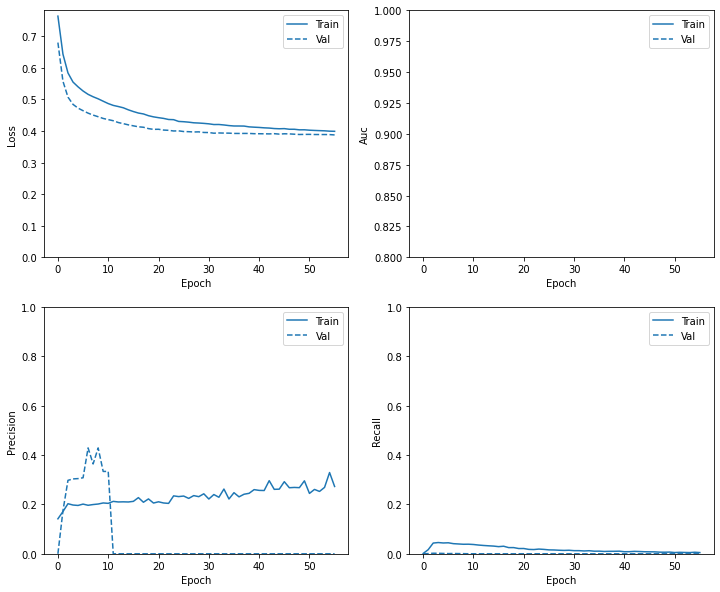

In [ ]:
plot_metrics(gan_history)

In [ ]:
np.random.seed(45)
train_predictions_gan = model.predict(train_featuresgan, batch_size=BATCH_SIZE)
test_predictions_gan = model.predict(test_featuresgan, batch_size=BATCH_SIZE)

In [ ]:
np.random.seed(46)
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.38864052295684814
tp :  0.0
fp :  0.0
tn :  126307.0
fn :  19513.0
accuracy :  0.8661843538284302
precision :  0.0
recall :  0.0
auc :  0.6191192269325256

Legitimate Transactions Detected (True Negatives):  126307
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  19513
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  19513


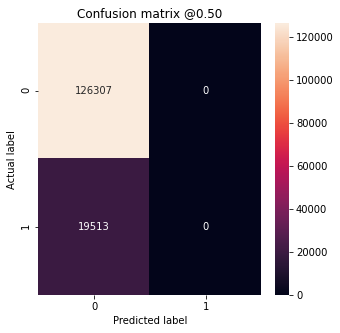

In [ ]:
np.random.seed(477)
gan_results = model.evaluate(train_featuresgan, train_labelsgan,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, gan_results):
  print(name, ': ', value)
print()

plot_cm(train_labelsgan, train_predictions_gan)

loss :  0.3973640203475952
tp :  0.0
fp :  0.0
tn :  39289.0
fn :  6280.0
accuracy :  0.8621870279312134
precision :  0.0
recall :  0.0
auc :  0.6165697574615479

Legitimate Transactions Detected (True Negatives):  39289
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  6280
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  6280


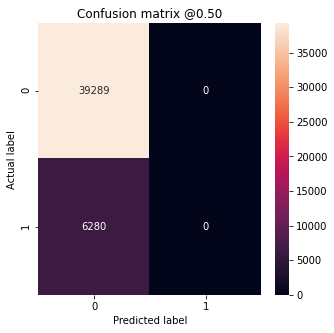

In [ ]:
np.random.seed(47)
gan_results = model.evaluate(test_featuresgan, test_labelsgan,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, gan_results):
  print(name, ': ', value)
print()

plot_cm(test_labelsgan, test_predictions_gan)

In [ ]:
np.random.seed(48)
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

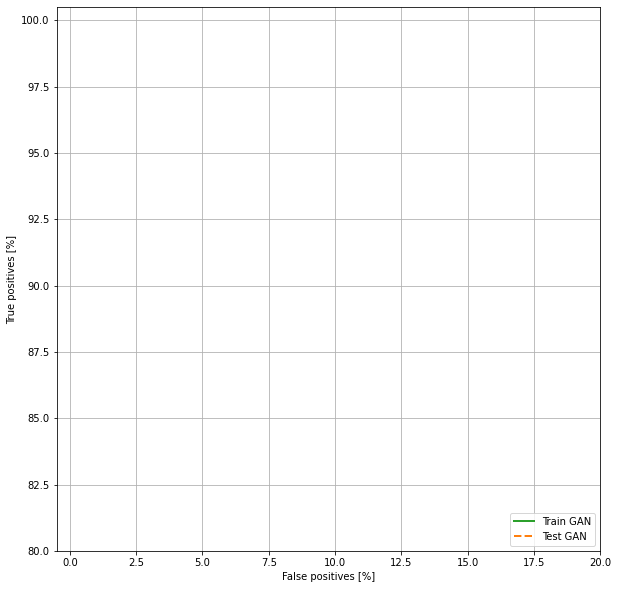

In [ ]:
plot_roc("Train GAN", train_labelsgan, train_predictions_gan, color=colors[2])
plot_roc("Test GAN", test_labelsgan, test_predictions_gan, color=colors[1], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
np.random.seed(1) 
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [ ]:
np.random.seed(2) 
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


In [ ]:
np.random.seed(3) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
np.random.seed(4) 
#train_features, train_labels
train_features_sm, train_labels_sm = sm.fit_sample(train_features, train_labels.ravel()) 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:

print('Before OverSampling: Training labels shape:', train_labels.shape)
print('After OverSampling: Training labels shape:', train_labels_sm.shape)
print('Before OverSampling: Training features shape:', train_features.shape)
print('After OverSampling: Training features shape:', train_features_sm.shape)

Before OverSampling: Training labels shape: (182276,)
After OverSampling: Training labels shape: (363912,)
Before OverSampling: Training features shape: (182276, 29)
After OverSampling: Training features shape: (363912, 29)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


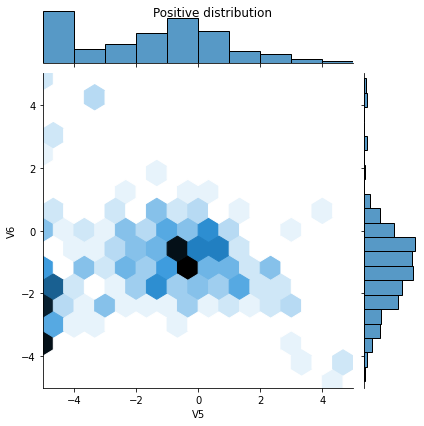

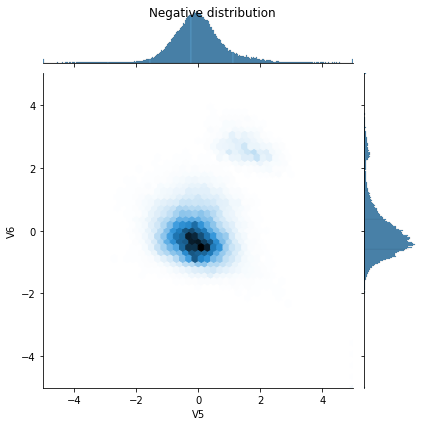

In [ ]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(train_labels == 1))) 
print("Before OverSampling, counts of label '0': {}".format(sum(train_labels == 0)))
print("After OverSampling, counts of label '1': {}".format(sum(train_labels_sm == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(train_labels_sm == 0)))

Before OverSampling, counts of label '1': 320
Before OverSampling, counts of label '0': 181956
After OverSampling, counts of label '1': 181956
After OverSampling, counts of label '0': 181956


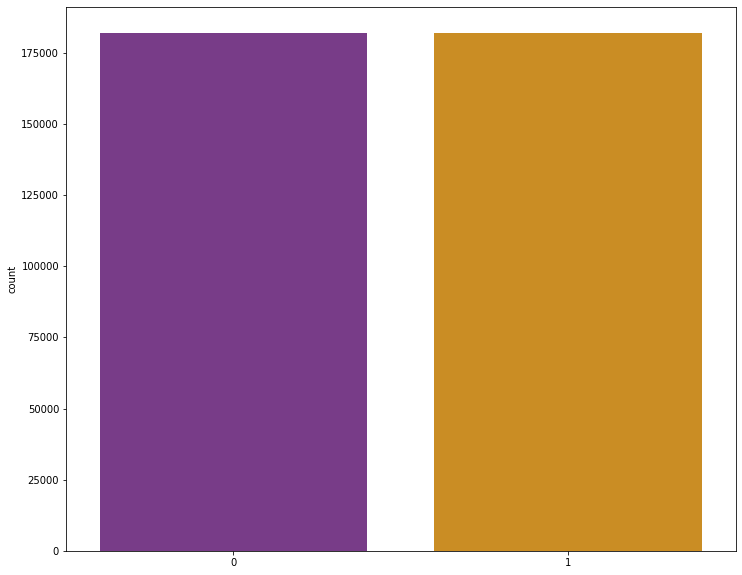

In [ ]:
sns.countplot(x=train_labels_sm, data=cleaned_df, palette='CMRmap')

In [ ]:
np.random.seed(501) 
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [ ]:
np.random.seed(601) 
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
np.random.seed(701) 
model = make_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16)                480       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [ ]:
np.random.seed(8) 
model.predict(train_features_sm[:10])

array([[0.7123371 ],
       [0.20765407],
       [0.55637515],
       [0.5050961 ],
       [0.5498509 ],
       [0.26211217],
       [0.41922498],
       [0.68840724],
       [0.57860994],
       [0.50671476]], dtype=float32)

In [ ]:
np.random.seed(9) 
results = model.evaluate(train_features_sm, train_labels_sm, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.6592


In [ ]:
np.random.seed(10) 
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [ ]:
np.random.seed(11) 
model = make_model(output_bias=initial_bias)
model.predict(train_features_sm[:10])

array([[0.00118504],
       [0.00118152],
       [0.00337738],
       [0.00124159],
       [0.00086717],
       [0.00366427],
       [0.00160843],
       [0.00127025],
       [0.00121179],
       [0.00141764]], dtype=float32)

In [ ]:
np.random.seed(12) 
results = model.evaluate(train_features_sm, train_labels_sm, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 3.0453


In [ ]:
np.random.seed(13) 
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [ ]:
np.random.seed(14) 
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features_sm,
    train_labels_sm,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [ ]:
np.random.seed(15) 
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features_sm,
    train_labels_sm,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [ ]:
np.random.seed(16) 
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch, history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

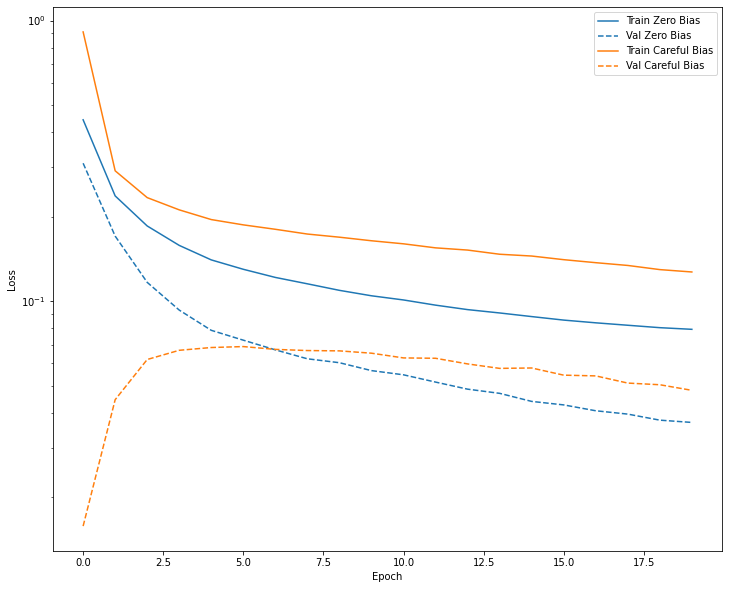

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [ ]:
np.random.seed(17) 
model = make_model()
model.load_weights(initial_weights)
start_time = time.time()
sm_history = model.fit(
    train_features_sm,
    train_labels_sm,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))
end_time = time.time()
print ("Computational time = " +str(end_time - start_time) )

Epoch 1/100
178/178 [==============================] - 2s 9ms/step - loss: 0.9130 - tp: 108374.0000 - fp: 816.0000 - tn: 226624.0000 - fn: 73667.0000 - accuracy: 0.8181 - precision: 0.9925 - recall: 0.5953 - auc: 0.8810 - val_loss: 0.0157 - val_tp: 70.0000 - val_fp: 38.0000 - val_tn: 45446.0000 - val_fn: 15.0000 - val_accuracy: 0.9988 - val_precision: 0.6481 - val_recall: 0.8235 - val_auc: 0.9363
Epoch 2/100
178/178 [==============================] - 1s 6ms/step - loss: 0.2923 - tp: 154982.0000 - fp: 2710.0000 - tn: 179246.0000 - fn: 26974.0000 - accuracy: 0.9184 - precision: 0.9828 - recall: 0.8518 - auc: 0.9605 - val_loss: 0.0448 - val_tp: 72.0000 - val_fp: 479.0000 - val_tn: 45005.0000 - val_fn: 13.0000 - val_accuracy: 0.9892 - val_precision: 0.1307 - val_recall: 0.8471 - val_auc: 0.9411
Epoch 3/100
178/178 [==============================] - 1s 6ms/step - loss: 0.2337 - tp: 161001.0000 - fp: 4726.0000 - tn: 177230.0000 - fn: 20955.0000 - accuracy: 0.9294 - precision: 0.9715 - recall

In [ ]:
np.random.seed(18) 
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


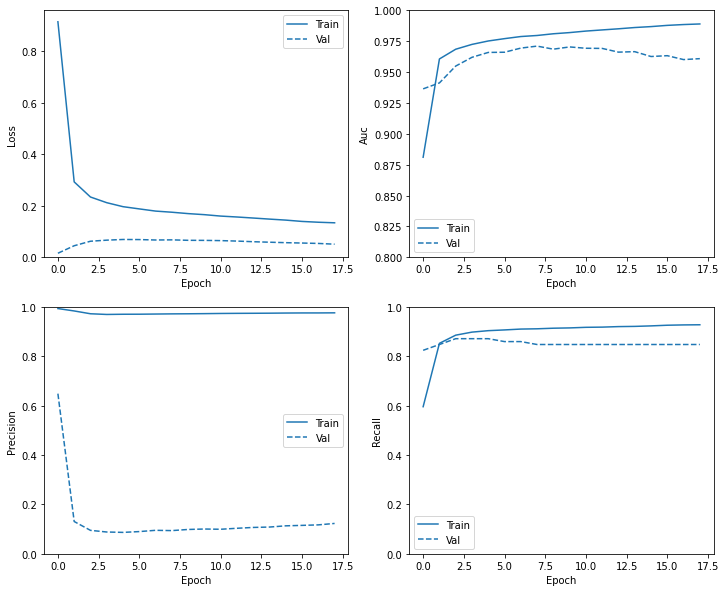

In [ ]:
plot_metrics(sm_history)

In [ ]:
np.random.seed(19) 
train_predictions_sm = model.predict(train_features_sm, batch_size=BATCH_SIZE)
test_predictions_sm = model.predict(test_features, batch_size=BATCH_SIZE)

In [ ]:
np.random.seed(20) 
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.06783374398946762
tp :  75.0
fp :  863.0
tn :  56012.0
fn :  12.0
accuracy :  0.9846388697624207
precision :  0.07995735853910446
recall :  0.8620689511299133
auc :  0.9774882793426514

Legitimate Transactions Detected (True Negatives):  56012
Legitimate Transactions Incorrectly Detected (False Positives):  863
Fraudulent Transactions Missed (False Negatives):  12
Fraudulent Transactions Detected (True Positives):  75
Total Fraudulent Transactions:  87


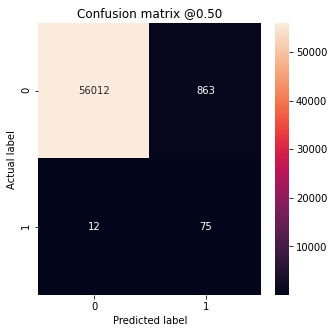

In [ ]:
np.random.seed(21) 
sm_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, sm_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_sm)

In [ ]:
np.random.seed(22) 
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

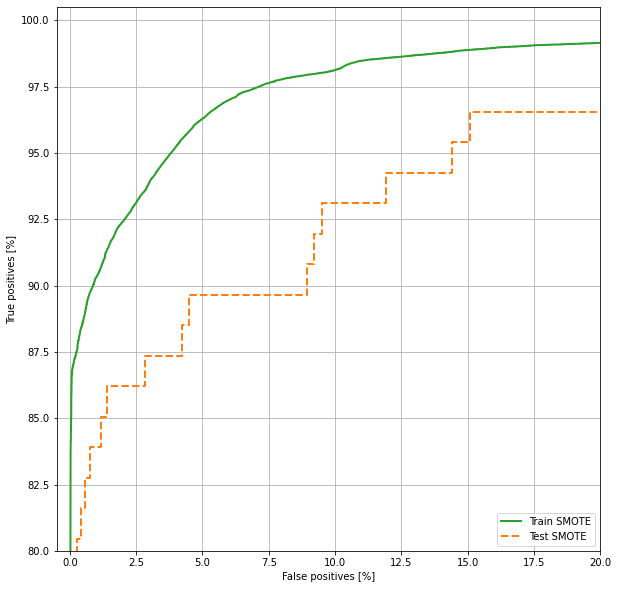

In [ ]:

plot_roc("Train SMOTE", train_labels_sm, train_predictions_sm, color=colors[2])
plot_roc("Test SMOTE", test_labels, test_predictions_sm, color=colors[1], linestyle='--')
plt.legend(loc='lower right')

## Train the model without balance

In [ ]:
np.random.seed(23) 
model = make_model()
model.load_weights(initial_weights)
start_time = time.time()
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))
end_time = time.time()
print ("Computational time = " +str(end_time - start_time) )

Epoch 1/100
90/90 [==============================] - 1s 14ms/step - loss: 0.0104 - tp: 135.0000 - fp: 880.0000 - tn: 237951.0000 - fn: 272.0000 - accuracy: 0.9952 - precision: 0.1330 - recall: 0.3317 - auc: 0.7640 - val_loss: 0.0057 - val_tp: 29.0000 - val_fp: 5.0000 - val_tn: 45479.0000 - val_fn: 56.0000 - val_accuracy: 0.9987 - val_precision: 0.8529 - val_recall: 0.3412 - val_auc: 0.8997
Epoch 2/100
90/90 [==============================] - 1s 7ms/step - loss: 0.0068 - tp: 141.0000 - fp: 27.0000 - tn: 181929.0000 - fn: 179.0000 - accuracy: 0.9989 - precision: 0.8393 - recall: 0.4406 - auc: 0.8774 - val_loss: 0.0046 - val_tp: 54.0000 - val_fp: 6.0000 - val_tn: 45478.0000 - val_fn: 31.0000 - val_accuracy: 0.9992 - val_precision: 0.9000 - val_recall: 0.6353 - val_auc: 0.8998
Epoch 3/100
90/90 [==============================] - 1s 6ms/step - loss: 0.0058 - tp: 163.0000 - fp: 31.0000 - tn: 181925.0000 - fn: 157.0000 - accuracy: 0.9990 - precision: 0.8402 - recall: 0.5094 - auc: 0.9175 - va

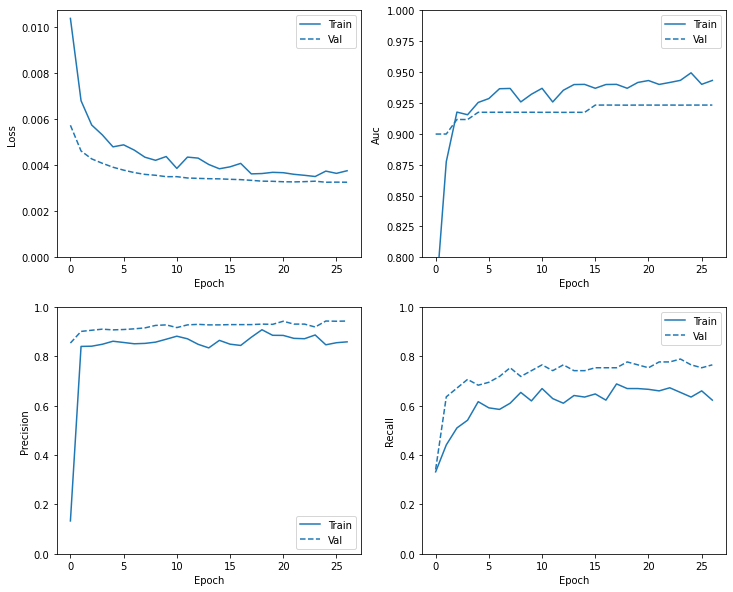

In [ ]:
np.random.seed(24)
plot_metrics(baseline_history)


In [ ]:
np.random.seed(25)
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.003441808745265007
tp :  63.0
fp :  11.0
tn :  56864.0
fn :  24.0
accuracy :  0.9993855357170105
precision :  0.8513513803482056
recall :  0.7241379022598267
auc :  0.9019393920898438

Legitimate Transactions Detected (True Negatives):  56864
Legitimate Transactions Incorrectly Detected (False Positives):  11
Fraudulent Transactions Missed (False Negatives):  24
Fraudulent Transactions Detected (True Positives):  63
Total Fraudulent Transactions:  87


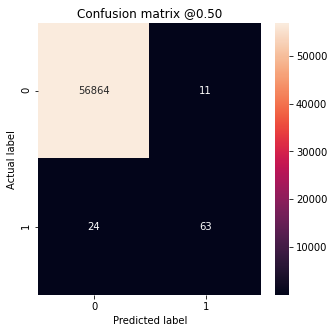

In [ ]:
np.random.seed(26)
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

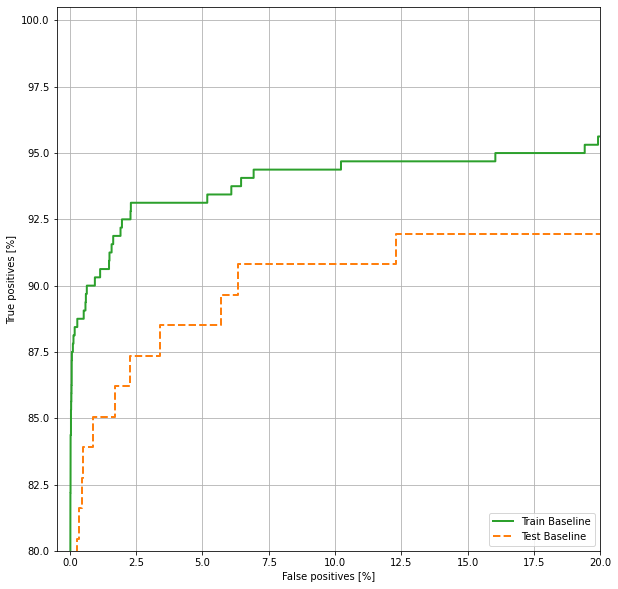

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[2])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[1], linestyle='--')
plt.legend(loc='lower right')

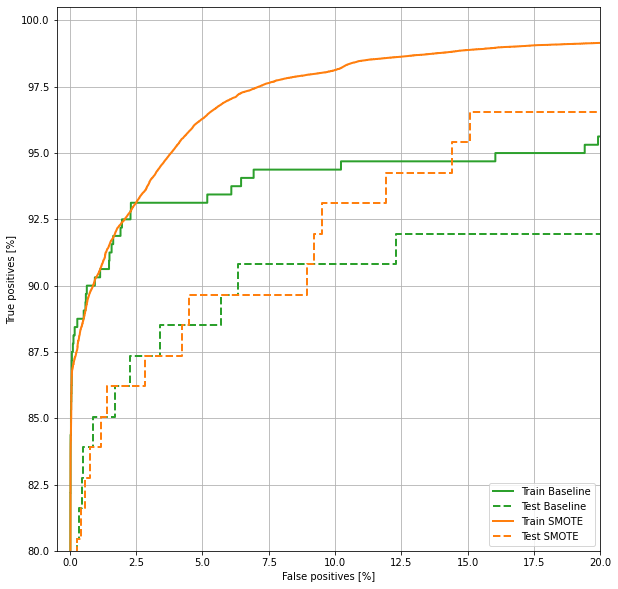

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[2])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[2], linestyle='--')

plot_roc("Train SMOTE", train_labels_sm, train_predictions_sm, color=colors[1])
plot_roc("Test SMOTE", test_labels, test_predictions_sm, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

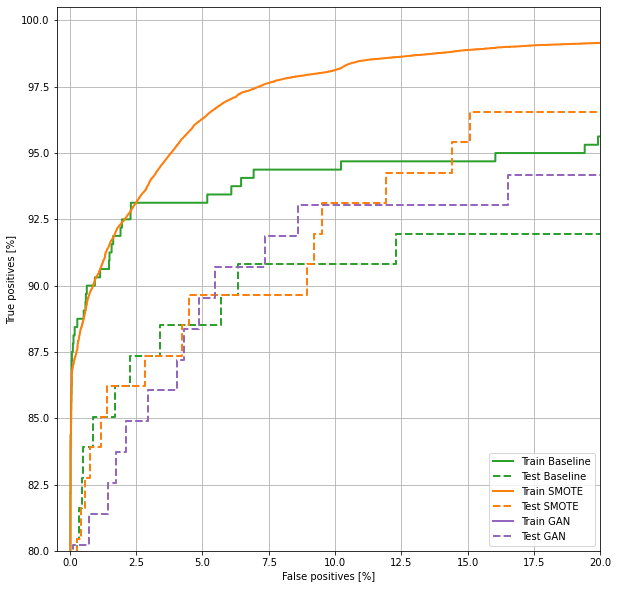

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[2])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[2], linestyle='--')

plot_roc("Train SMOTE", train_labels_sm, train_predictions_sm, color=colors[1])
plot_roc("Test SMOTE", test_labels, test_predictions_sm, color=colors[1], linestyle='--')

plot_roc("Train GAN", train_labelsgan, train_predictions_gan, color=colors[4])
plot_roc("Test GAN", test_labelsgan, test_predictions_gan, color=colors[4], linestyle='--')
plt.legend(loc='lower right')

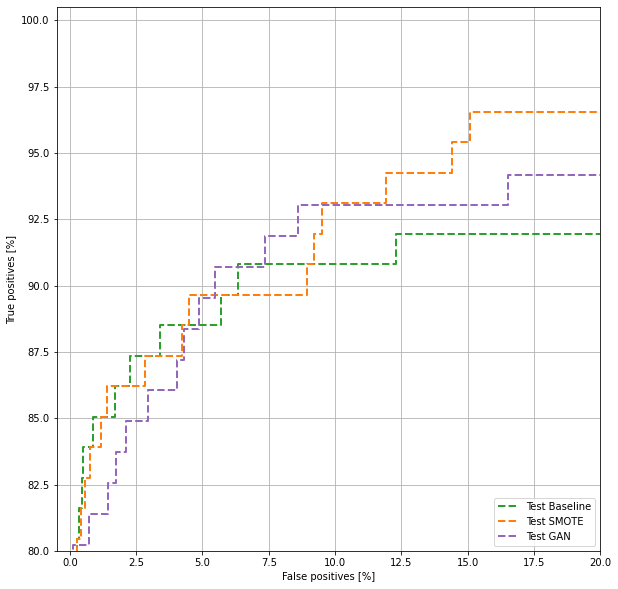

In [ ]:
#plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[2])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[2], linestyle='--')

#plot_roc("Train SMOTE", train_labels_sm, train_predictions_sm, color=colors[1])
plot_roc("Test SMOTE", test_labels, test_predictions_sm, color=colors[1], linestyle='--')

#plot_roc("Train GAN", train_labelsgan, train_predictions_gan, color=colors[4])
plot_roc("Test GAN", test_labelsgan, test_predictions_gan, color=colors[4], linestyle='--')
plt.legend(loc='lower right')

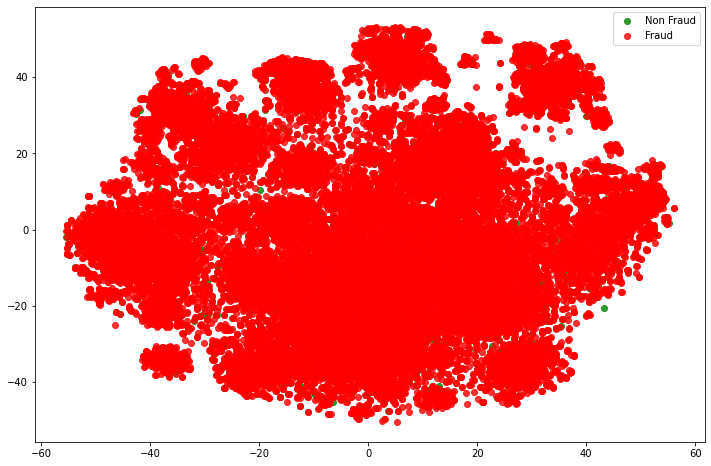

Computational time = 343.7595784664154


In [ ]:
np.random.seed(110) 
non_fraud = gan_samples [gan_samples ['Class'] == 0].sample(50000)
fraud = gan_samples [gan_samples ['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values
np.random.seed(12) 
from sklearn.manifold import TSNE
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();

status_start_time = time.time()    
tsne_plot(X, Y, "original.png")
status_end_time=time.time()
print ("Computational time = " +str(status_end_time - status_start_time) )

In [ ]:
np.random.seed(81) 
clf_best_rf = RandomForestClassifier(n_estimators=1000, oob_score=True, random_state=0, n_jobs=-1)

In [ ]:
np.random.seed(82) 
start_time = time.time()
clf_best_rf.fit(train_featuresgan, train_labelsgan)
end_time = time.time()
print ("Computational time = " +str(end_time - start_time) )

Computational time = 1274.1245203018188


In [ ]:
np.random.seed(83) 
print('5-fold cross-validation score on selected features for test data:', np.mean(cross_val_score(clf_best_rf,train_featuresgan, train_labelsgan, cv=5,scoring='roc_auc')))

5-fold cross-validation score on selected features for test data: 0.6056033103032231


In [ ]:
np.random.seed(84) 
print('5-fold cross-validation score on selected features for test data:', np.mean(cross_val_score(clf_best_rf,val_featuresgan, val_labelsgan, cv=5,scoring='roc_auc')))

5-fold cross-validation score on selected features for test data: 0.6008504345948308


In [ ]:
np.random.seed(85) 
print('5-fold cross-validation score on selected features for test data:', np.mean(cross_val_score(clf_best_rf,test_featuresgan, test_labelsgan, cv=5,scoring='roc_auc')))

5-fold cross-validation score on selected features for test data: 0.9473877918970249


In [ ]:
np.random.seed(812) 
clf_best_rf = RandomForestClassifier(n_estimators=1000, oob_score=True, random_state=0, n_jobs=-1)

In [ ]:
np.random.seed(823) 
start_time = time.time()
clf_best_rf.fit(train_features, train_labels)
end_time = time.time()
print ("Computational time = " +str(end_time - start_time) )

Computational time = 927.8703691959381


In [ ]:
np.random.seed(834) 
start_time = time.time()
print('5-fold cross-validation score on selected features for test data:', np.mean(cross_val_score(clf_best_rf,train_features, train_labels, cv=5,scoring='roc_auc')))
end_time = time.time()
print ("Computational time = " +str(end_time - start_time) )

5-fold cross-validation score on selected features for test data: 0.9672973983273436
Computational time = 3745.752977848053


In [ ]:
np.random.seed(855) 
start_time = time.time()
print('5-fold cross-validation score on selected features for test data:', np.mean(cross_val_score(clf_best_rf,test_features, test_labels, cv=5,scoring='roc_auc')))
end_time = time.time()
print ("Computational time = " +str(end_time - start_time) )

5-fold cross-validation score on selected features for test data: 0.9288922789628673
Computational time = 711.7167162895203


In [ ]:
df1 = cleaned_df.sample(2)
df1.head()


(2, 30)

In [ ]:
cleaned_df.shape


(284807, 30)

In [ ]:
284807/2

142403.5

In [ ]:
gan_samples.shape

(227845, 30)

In [ ]:
df2=gan_samples.sample(100000)
df2.shape

(100000, 30)

In [ ]:
df2.head()

V1        V2        V3  ...       V28  Class  Log Ammount
200547 -0.535637  1.259841  0.198811  ...  0.933943      1     0.193240
56418  -0.619298  1.423259 -1.001158  ...  0.480072      1     0.040104

[2 rows x 30 columns]

In [ ]:
df=pd.concat([cleaned_df,df2])

In [ ]:
df.shape

(384807, 30)

In [ ]:
df

V1        V2        V3  ...       V28  Class  Log Ammount
202755 -7.447801  6.642062 -3.896249  ...  0.867383      0     2.190647
240427  1.292596 -1.447253 -3.528283  ... -0.024738      0     6.150605
200547 -0.535637  1.259841  0.198811  ...  0.933943      1     0.193240
56418  -0.619298  1.423259 -1.001158  ...  0.480072      1     0.040104

[4 rows x 30 columns]

In [ ]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [ ]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (246276,)
Validation labels shape: (61569,)
Test labels shape: (76962,)
Training features shape: (246276, 29)
Validation features shape: (61569, 29)
Test features shape: (76962, 29)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


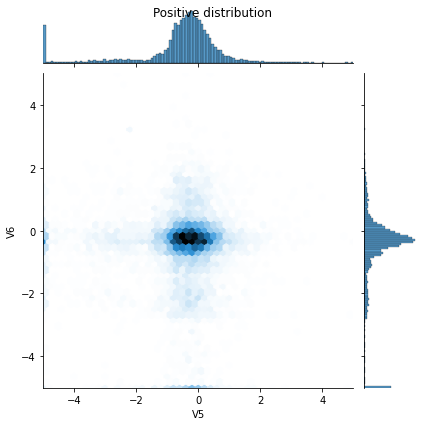

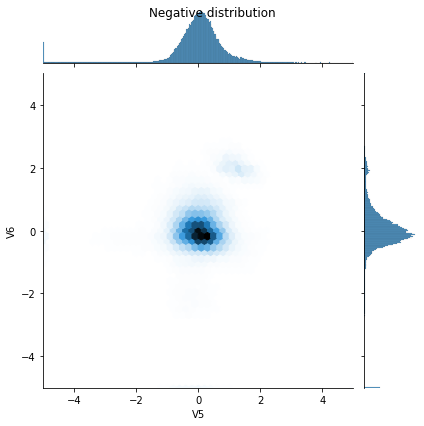

In [ ]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [ ]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
model = make_model()
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 16)                480       
_________________________________________________________________
dropout_22 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.predict(train_features[:10])

array([[0.66615504],
       [0.59647495],
       [0.63008416],
       [0.37283954],
       [0.43778643],
       [0.39627585],
       [0.7283143 ],
       [0.6317164 ],
       [0.5573303 ],
       [0.50840575]], dtype=float32)

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.7511


In [ ]:
neg, pos = np.bincount(df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 384807
    Positive: 13953 (3.63% of total)



In [ ]:
initial_bias = np.log([pos/neg])
initial_bias

array([-3.28011392])

In [ ]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.17927548],
       [0.04358854],
       [0.03739426],
       [0.02309815],
       [0.01528488],
       [0.01166743],
       [0.06370675],
       [0.05337797],
       [0.07207168],
       [0.05085072]], dtype=float32)

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.2201


In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [ ]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch, history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

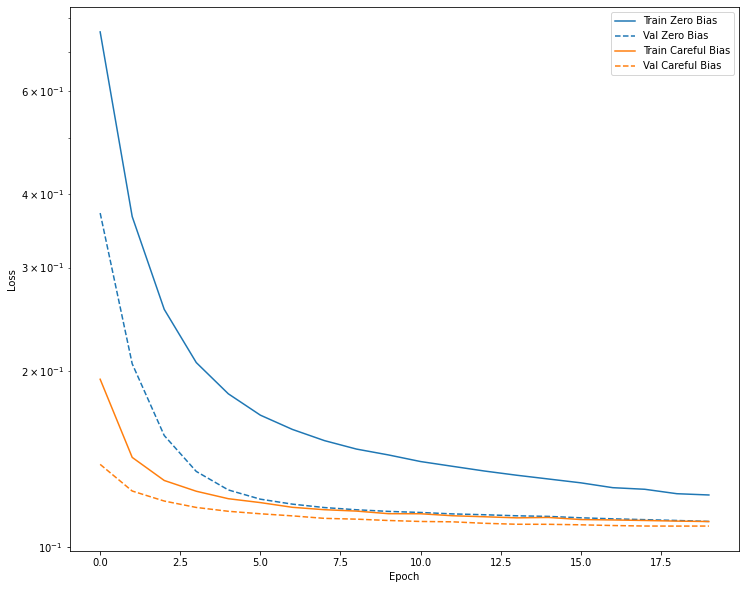

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
121/121 [==============================] - 1s 11ms/step - loss: 0.1934 - tp: 474.0000 - fp: 4168.0000 - tn: 292546.0000 - fn: 10657.0000 - accuracy: 0.9518 - precision: 0.1021 - recall: 0.0426 - auc: 0.6783 - val_loss: 0.1383 - val_tp: 13.0000 - val_fp: 28.0000 - val_tn: 59285.0000 - val_fn: 2243.0000 - val_accuracy: 0.9631 - val_precision: 0.3171 - val_recall: 0.0058 - val_auc: 0.7982
Epoch 2/100
121/121 [==============================] - 1s 6ms/step - loss: 0.1420 - tp: 341.0000 - fp: 1090.0000 - tn: 236311.0000 - fn: 8534.0000 - accuracy: 0.9609 - precision: 0.2383 - recall: 0.0384 - auc: 0.7735 - val_loss: 0.1246 - val_tp: 35.0000 - val_fp: 21.0000 - val_tn: 59292.0000 - val_fn: 2221.0000 - val_accuracy: 0.9636 - val_precision: 0.6250 - val_recall: 0.0155 - val_auc: 0.8770
Epoch 3/100
121/121 [==============================] - 1s 6ms/step - loss: 0.1299 - tp: 332.0000 - fp: 722.0000 - tn: 236679.0000 - fn: 8543.0000 - accuracy: 0.9624 - precision: 0.3150 - recall: 0.037

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

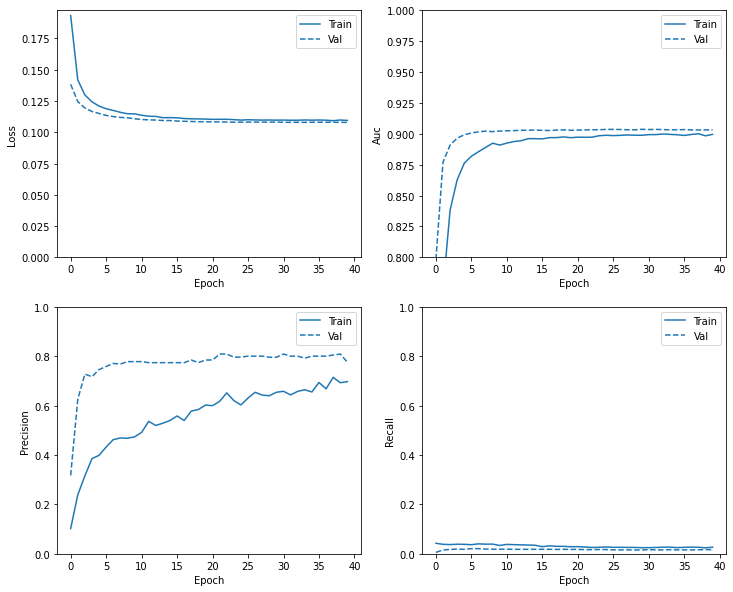

In [ ]:
plot_metrics(baseline_history)

In [ ]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.10672072321176529
tp :  56.0
fp :  9.0
tn :  74131.0
fn :  2766.0
accuracy :  0.9639432430267334
precision :  0.8615384697914124
recall :  0.01984408311545849
auc :  0.9067343473434448

Legitimate Transactions Detected (True Negatives):  74131
Legitimate Transactions Incorrectly Detected (False Positives):  9
Fraudulent Transactions Missed (False Negatives):  2766
Fraudulent Transactions Detected (True Positives):  56
Total Fraudulent Transactions:  2822


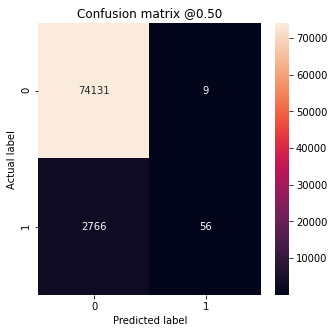

In [ ]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

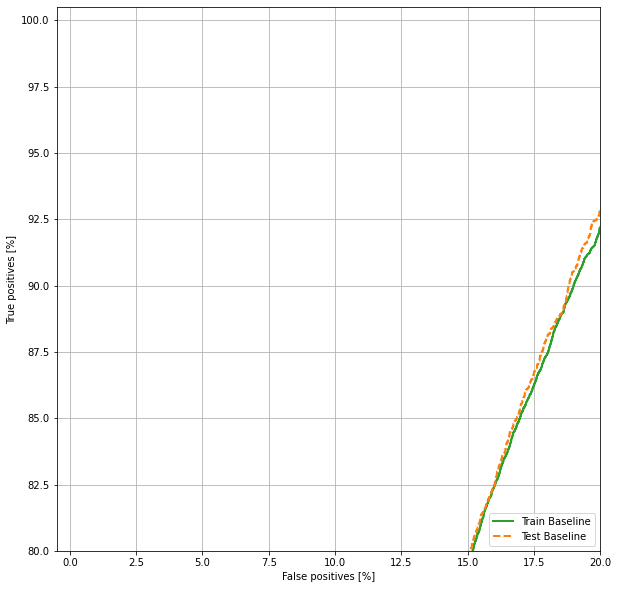

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[2])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[1], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
np.random.seed(8199) 
clf_best_rf = RandomForestClassifier(n_estimators=1000, oob_score=True, random_state=0, n_jobs=-1)

In [ ]:
np.random.seed(8299) 
start_time = time.time()
clf_best_rf.fit(train_features, train_labels)
end_time = time.time()
print ("Computational time = " +str(end_time - start_time) )

Computational time = 2522.847931623459


In [ ]:
np.random.seed(83499) 
start_time = time.time()
print('5-fold cross-validation score on selected features for test data:', np.mean(cross_val_score(clf_best_rf,train_features, train_labels, cv=5,scoring='roc_auc')))
end_time = time.time()
print ("Computational time = " +str(end_time - start_time) )

In [ ]:
np.random.seed(8499) 
print('5-fold cross-validation score on selected features for test data:', np.mean(cross_val_score(clf_best_rf,val_features, val_labels, cv=5,scoring='roc_auc')))

In [ ]:
np.random.seed(85599) 
start_time = time.time()
print('5-fold cross-validation score on selected features for test data:', np.mean(cross_val_score(clf_best_rf,test_features, test_labels, cv=5,scoring='roc_auc')))
end_time = time.time()
print ("Computational time = " +str(end_time - start_time) )